In [1]:
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import xarray as xr

from src.analysis.load_SAIdata import open_mfdataset, Cases
import src.analysis.tracks as tracks

%matplotlib inline

In [2]:
exps = {'ref':'Reference', 'rcp':'RCP8.5', 'sai':'SAI2050'}
experiment = 'ref'
run_ensemble = 6
Exp = exps[experiment]
stream, stream_prec = ('h1','h2') if (experiment in ('ref','rcp')) and (run_ensemble <= 5) else ('h5','h3')
savefile = f'PRECT_sum.{experiment}.{run_ensemble}.nc'
print(f'{Exp=}, {stream=}, {stream_prec=}, {savefile=}')

Exp='Reference', stream='h5', stream_prec='h3', savefile='PRECT_sum.ref.6.nc'


In [3]:
def read_CAM_prect(experiment, run_ensemble, stream_prec):
    case = Cases(f'hres.{experiment}.{run_ensemble}').select('atm',stream_prec)
    ds_cam = case.open_mfdataset(decode_times=False)
    ds_cam = ds_cam.drop_vars(('date_written','time_written'))
    dt = (ds_cam.time[1] - ds_cam.time[0]).item() # time step (days)
    if 'time: mean' in getattr(ds_cam.PRECT, 'cell_methods', ''):
        ds_cam['time'] = ds_cam['time_bnds'].mean('nbnd', keep_attrs=False).assign_attrs(ds_cam.time.attrs)
    if dt == 0.125:
        print('converting 3hrly avg precipitation to 6hrly')
        ds_cam = ds_cam.coarsen(time=2).mean(keep_attrs=True)
    dt = (ds_cam.time[1] - ds_cam.time[0]).item() # time step (days)
    assert dt == 0.25, f'precipitation should be 6hrly, but {dt=}'
    return ds_cam

In [4]:
def get_timestamps(ds):
    """for each year, create array of timestamps at which TCs are active
    
    ds : xr.Dataset
        track dataset

    returns : 
    track_times : dict(str, arr)
        mapping from year to array of timestamps
    """
    track_times = {}
    for year in np.unique(ds.year):
        if np.isnan(year):
            continue
        dsi = ds.where(ds.year==year, drop=True)
        track_times_i = np.sort(np.unique(dsi.time))
        track_times_i = track_times_i[~np.isnan(track_times_i)]
        track_times[f'{int(year)}'] = track_times_i
        # print(int(year), len(track_times_i)/8) # days with active TCs
    return track_times

# dsi = ds_tracks[Exp].where(ds_tracks[Exp].ens==run_ensemble, drop=True)
# track_times = get_timestamps(dsi)
# track_times

In [5]:
def circular_mask_TC(TC_lon, TC_lat, ds, r=5):
    """create circular mask of r degrees around TC
    using periodic boundary conditions for longitude

    TC_lon, TC_lat : float, float
        longitude and latitude of TC

    ds : xr.Dataset
        should contain lon and lat fields

    r : int | float
        radius of circular mask in degrees

    returns:
    circlemask : bool (ds.lat.size x ds.lon.size)
        true where distance to TC is less than or equal to r
    """
    assert r > 0, 'r must be positive'
    assert r < 30, 'can only handle radii <30degs to prevent issues near the poles'
    dlon = (ds.lon-TC_lon+180)%360 - 180 
    dlat = ds.lat-TC_lat
    circlemask = np.sqrt(dlat**2 + dlon**2) <= r
    return circlemask

# mask = circular_mask_TC(0,25,ds_cam,r=25)
# mask.plot(x='lon')
# plt.grid()

In [6]:
def join_TC_masks(ids, ds_tracks, ds_cam, r=5):
    """create mask field that is true within r degrees of any TC

    ids : array of int (N x 2)
        point coordinates (id x dtime) of (N) TCs

    ds_tracks, ds_cam : xr.Dataset
        track / CAM dataset

    r : int | float
        radius of circular mask around individual TCs

    returns:
    joined_masks : bool (ds_cam.lat.size x ds_cam.lon.size)
        joined circular mask field
        true where distance to any TC is smaller than or equal to r
    """
    masks = [xr.zeros_like(ds_cam.lat * ds_cam.lon, dtype='bool')]
    for (tid,dt) in ids:  # loop through active TCs
        ds_TC = ds_tracks.isel(id=tid, dtime=dt)
        mask = circular_mask_TC(ds_TC.lon, ds_TC.lat, ds_cam, r)
        masks.append(mask)
    masks = xr.concat(masks, dim='n', coords='minimal', compat='override')
    joined_masks = masks.any('n')
    return joined_masks


def interpolate_time(time, da):
    """linearly interpolate da to time step 'time'

    time : float
        time to interpolate to

    da : xr.DataArray
        data to interpolate (must have time coordinate)

    returns:
    da_interp : xr.DataArray
        da interpolated to 'time'
    """
    if time in da.time:
        return da.sel(time=time)
    ax = da.dims.index('time')
    id1 = np.searchsorted(da.time, time)
    id0 = max(id1 - 1, 0)
    da_adj = da.isel(time=slice(id0,id1+1))
    interped = interp1d(da_adj.time, da_adj, axis=ax)(time)
    da_interp = da.isel(time=0)
    da_interp.time.data = time
    da_interp.data = interped
    return da_interp


def main():
    dsi_tracks = ds_tracks[Exp].where(ds_tracks[Exp].ens==run_ensemble, drop=True)  # select tracks for experiment and ensemble
    track_times = get_timestamps(dsi_tracks)
    precip_sum = {}
    dt = 3 * 60 * 60 # time difference (s) between track points
    for (year,timestamps) in track_times.items():  # loop through years
        print(year)
        pcip_sum_year = xr.zeros_like(ds_cam.lat*ds_cam.lon, dtype='float32')
        pcip_sum_year = (pcip_sum_year
                         .rename('PRECT')
                         .assign_coords(year=int(year))
                         .assign_attrs({'name':'PRECT','long_name':'precipitation sum','units':'mm/year'}))
        for time in timestamps[0:80]:  # loop through time stamps with active TCs
            if (time - timestamps[0])%1==0:
                print('\rcurrent day of year:',time-timestamps[0]+1, end=', ')
            PRECT_step = interpolate_time(time, ds_cam.PRECT) # 6hrly average precipitation (m/s)
            ids = np.nonzero(dsi_tracks.time == time).T  # IDs of active TCs at time step
            mask = join_TC_masks(ids, dsi_tracks, ds_cam, r=5) # mask (Nlat x Nlon), true within r degrees of any TC
            dPRECT = mask.astype('int') * PRECT_step * dt * 1000 # precipitation sum (mm) over 3hr interval between track points
            pcip_sum_year += dPRECT.compute()
        print('')
        precip_sum[year] = pcip_sum_year.drop_vars(('time','id','dtime'))
    
    # save results
    ds = xr.concat(precip_sum.values(), dim='year').to_dataset()
    ds.to_netcdf(savefile)
    return 

In [7]:
ds_cam = read_CAM_prect(experiment, run_ensemble, stream_prec)
ds_tracks = tracks.load_tracks('../../jobs/Tracking_TC_RV.infext2/', ext='.infext')

Reading combined kerchunk reference file /home/jasperdj/kerchunk/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001.cam2.h3.2002-12-01-21600_2007-12-01-21600.json
REF.001: 5.000 years, 470 tracks
REF.002: 5.000 years, 480 tracks
REF.003: 5.000 years, 490 tracks
REF.004: 5.000 years, 493 tracks
REF.005: 5.000 years, 514 tracks
REF.006: 5.000 years, 454 tracks
RCP.001: 5.000 years, 440 tracks
RCP.002: 5.000 years, 439 tracks
RCP.003: 5.000 years, 457 tracks
RCP.004: 5.000 years, 458 tracks
RCP.005: 5.000 years, 451 tracks
RCP.006: 5.000 years, 468 tracks
SAI.001: 5.000 years, 422 tracks
SAI.002: 5.000 years, 436 tracks
SAI.003: 5.000 years, 407 tracks
SAI.004: 5.000 years, 428 tracks
SAI.005: 5.000 years, 409 tracks
SAI.006: 5.000 years, 413 tracks


In [8]:
%%time
main()

2003
current day of year: 10.0, 
2004
current day of year: 10.0, 
2005
current day of year: 11.0, 
2006
current day of year: 15.0, 
2007
current day of year: 10.0, 
CPU times: user 22.1 s, sys: 3.57 s, total: 25.7 s
Wall time: 25 s


In [17]:
ds = xr.open_dataset(savefile)

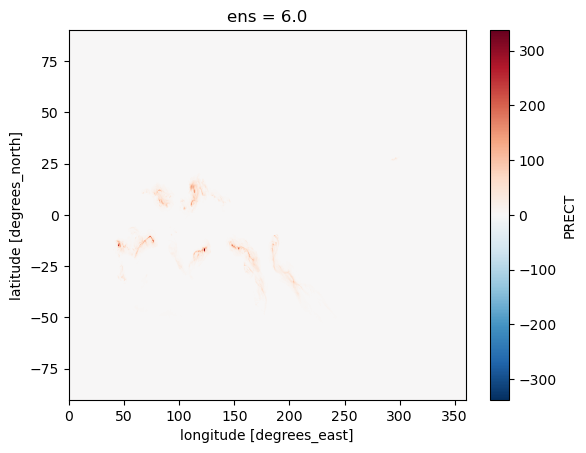

In [18]:
ds.PRECT.mean('year').plot()

In [11]:
ds.close()

In [15]:
pcip_sum_total = ((ds_cam.PRECT*6*60*60*1000).sum('time')/5).compute()

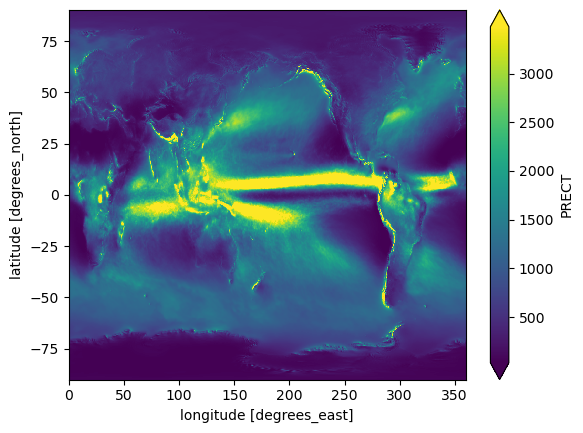

In [16]:
pcip_sum_total.plot(robust=True)

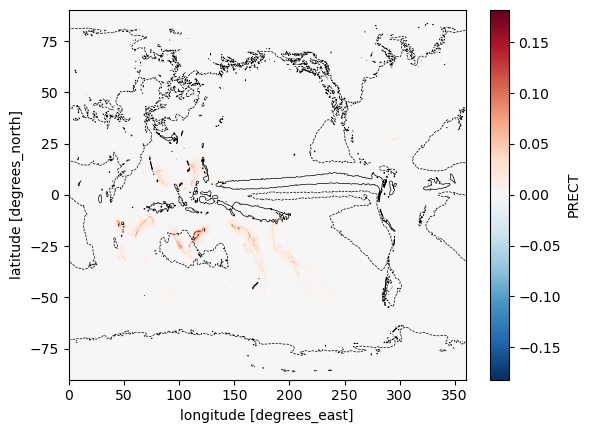

In [26]:
(ds.PRECT.mean('year')/pcip_sum_total).plot()
pcip_sum_total.plot.contour(levels=[500,3500], colors='k', linewidths=0.5, linestyles=['--','-'])

In [ ]:
ds.close()